In [1]:
from maze import maze_game
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

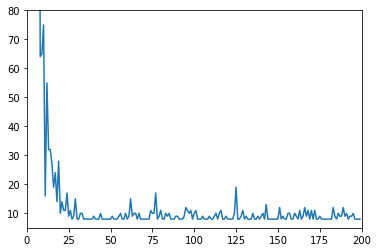

In [2]:

def epsilon_greedy_policy(state, q_table, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(4)
    return np.argmax(q_table[state])

class QLearningSolver():

    def __init__(self, env, policy):
        self.q_table = np.random.random((env.observation_space.n, env.action_space.n)) 
        self.lr = .1
        self.gamma = .99
        self.policy = policy
        self.env = env
        self.epsilon = .1

    def solve(self, num_episodes=500):
        steps = []
        for episodes in range(num_episodes):
            state = maze_env.reset()['state']
            done = False
            while not done:
                action = epsilon_greedy_policy(state, self.q_table, self.epsilon)
                new_state, reward, done, _, _ = maze_env.step(action)
                new_state = new_state['state']
                #Q Learning update 
                self.q_table[state, action] += self.lr * (reward + self.gamma * np.max(self.q_table[new_state, :]) - self.q_table[state, action])
                state = new_state
            steps.append(self.env.steps)
        return steps

num_trails = 1
num_episodes = 200
trails = []
for i in range(num_trails):
    maze_env = maze_game('easy')
    solver = QLearningSolver(maze_env, epsilon_greedy_policy)
    trails.append(solver.solve(num_episodes))

plt.axis([0, num_episodes, 5, 80])
plt.plot(np.array(trails).mean(axis=0))

In [5]:
class one_hot_maze(maze_game):
    def step(self, action):
        state, reward, done, _, _ = super().step(action)
        state_onehot = np.zeros(self.observation_space.n)
        state_onehot[state['state']] = 1
        return {'state': state_onehot}, reward, done, None, None
    
    def reset(self):
        state = super().reset()
        state_onehot = np.zeros(self.observation_space.n)
        state_onehot[state['state']] = 1
        return {'state': state_onehot}

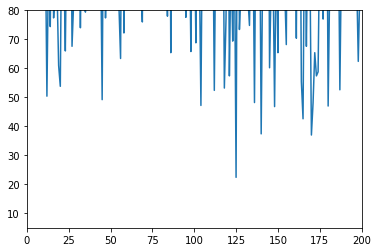

In [14]:
def softmax_policy(state, W):
    logits = np.dot(state['state'], W)
    softmax = np.exp(logits) / sum(np.exp(logits))
    action = np.random.choice(4, p=softmax)
    return action, softmax

class PolicyGradientSolver():

    def __init__(self, env, policy):
        self.W = np.random.random((env.observation_space.n, env.action_space.n)) 
        self.lr = .05
        self.gamma = .95
        self.policy = policy
        self.env = env

    def solve(self, num_episodes=500):
        steps = []
        for episodes in range(500):
            state = self.env.reset()
            rewards = []
            states = [state['state']]
            actions = []
            derivatives = []
            done = False
            while not done:
                action, probs = softmax_policy(state, self.W)
                probs = np.expand_dims(probs, 1)
                jacobian = np.diagflat(probs) - np.dot(probs, probs.T)
                derivatives.append(jacobian[action])
                actions.append(action)
                new_state, reward, done, _, _ = self.env.step(action)
                states.append(new_state['state'])
                rewards.append(reward)
                state = new_state
            steps.append(self.env.steps)
            states = np.array(states); actions = np.array(actions); derivatives = np.array(derivatives)
            gain = scipy.signal.lfilter([1], [1, float(-self.gamma)], np.array(rewards[::-1]), axis=0)[::-1]
            for i in range(derivatives.shape[0]):
                self.W[np.argmax(states[i]),:] += self.lr * derivatives[i] * gain[i]

        return steps

num_trails = 5
num_episodes = 200
trails = []
for i in range(num_trails):
    maze_env = one_hot_maze('easy')
    solver = PolicyGradientSolver(maze_env, softmax_policy)
    trails.append(solver.solve(num_episodes))

plt.axis([0, num_episodes, 5, 80])
plt.plot(np.array(trails).mean(axis=0))

<ipython-input-34-e43c1de7c865>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  states = np.array(states); actions = np.array(actions); derivatives = np.array(derivatives)


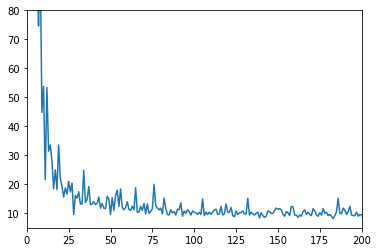

In [34]:
class PolicyGradientActorCriticSolver():

    def __init__(self, env, policy):
        self.W = np.random.random((env.observation_space.n, env.action_space.n)) 
        self.V = np.random.random((env.observation_space.n, 1)) 
        self.lr = .1
        self.gamma = .95
        self.policy = policy
        self.env = env
        self.value_lr = .1
        self.value_lambda = 0.99

    def solve(self, num_episodes=500):
        steps = []
        for episodes in range(500):
            state = self.env.reset()
            rewards = []
            states = [[state['state']]]
            actions = []
            derivatives = []
            done = False
            while not done:
                action, probs = softmax_policy(state, self.W)
                probs = np.expand_dims(probs, 1)
                jacobian = np.diagflat(probs) - np.dot(probs, probs.T)
                derivatives.append(jacobian[action])
                actions.append(action)
                new_state, reward, done, _, _ = self.env.step(action)
                states.append(new_state['state'])
                rewards.append(reward)
                state = new_state
            steps.append(self.env.steps)
            states = np.array(states); actions = np.array(actions); derivatives = np.array(derivatives)
            gain = scipy.signal.lfilter([1], [1, float(-self.gamma)], np.array(rewards[::-1]), axis=0)[::-1]
            for i in range(derivatives.shape[0]):
                self.W[np.argmax(states[i]),:] += self.lr * derivatives[i] * (gain[i] - np.dot(states[i], self.V)[0])

            #Simple gradient decent that takes advantage of the fact our state is one-hot
            for i in range(gain.shape[0]):
                self.V[np.argmax(states[i])] += self.value_lr * (gain[i] - np.dot(states[i], self.V)[0]) 
            self.value_lr *= self.value_lambda
        return steps

num_trails = 5
num_episodes = 200
trails = []
for i in range(5):
    maze_env = one_hot_maze('easy')
    solver = PolicyGradientActorCriticSolver(maze_env, softmax_policy)
    trails.append(solver.solve(num_episodes))

plt.axis([0, num_episodes, 5, 80])
plt.plot(np.array(trails).mean(axis=0))

In [15]:
class one_hot_maze_action_mask(one_hot_maze):
    def step(self, action):
        state, reward, done, _, _ = super().step(action)
        state = {'state': state}
        state['action_mask'] = self.get_action_mask()
        return state, reward, done, None, None
    
    def reset(self):
        state = super().reset()
        state = {'state': state}
        state['action_mask'] = self.get_action_mask()
        return state
    
    def get_action_mask(self):
        action_mask = np.zeros(4)
        if self.y != 0:
            if self.maze[self.x, self.y-1] != 'X':
                action_mask[0] = 1
        if self.x != 6:
            if self.maze[self.x+1, self.y] != 'X':
                action_mask[1] = 1
        if self.y != 6:
            if self.maze[self.x, self.y+1] != 'X':
                action_mask[2] = 1
        if self.x != 0:
            if self.maze[self.x-1, self.y] != 'X':
                action_mask[3] = 1
        return action_mask

<ipython-input-13-060553dc3225>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  states = np.array(states); actions = np.array(actions); derivatives = np.array(derivatives)


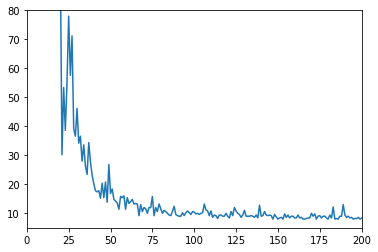

In [18]:
def softmax_policy_action_mask(state, W):
    logits = np.dot(state['state'], W)
    logits *= state['action_mask']
    softmax = np.exp(logits) / sum(np.exp(logits))
    action = np.random.choice(4, p=softmax)
    return action, softmax

num_trails = 5
num_episodes = 200
trails = []
for i in range(num_trails):
    maze_env = one_hot_maze('easy')
    solver = PolicyGradientActorCriticSolver(maze_env, softmax_policy_action_mask)
    trails.append(solver.solve(num_episodes))

plt.axis([0, num_episodes, 5, 80])
plt.plot(np.array(trails).mean(axis=0))

<ipython-input-34-e43c1de7c865>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  states = np.array(states); actions = np.array(actions); derivatives = np.array(derivatives)


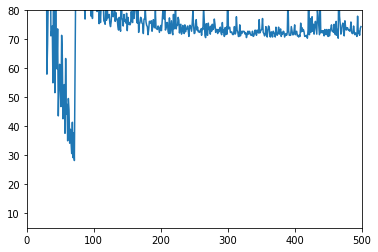

In [42]:
num_trails = 5
num_episodes = 500
trails = []
for i in range(num_trails):
    maze_env = one_hot_maze('hard')
    solver = PolicyGradientActorCriticSolver(maze_env, softmax_policy)
    solver.lr = .05
    solver.gamma = .97
    trails.append(solver.solve(num_episodes))

plt.axis([0, num_episodes, 5, 80])
plt.plot(np.array(trails).mean(axis=0))

<ipython-input-34-e43c1de7c865>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  states = np.array(states); actions = np.array(actions); derivatives = np.array(derivatives)


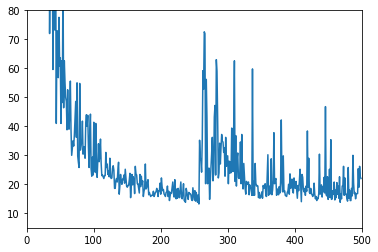

In [43]:
num_trails = 5
num_episodes = 500
trails = []
for i in range(num_trails):
    maze_env = one_hot_maze('hard')
    solver = PolicyGradientActorCriticSolver(maze_env, softmax_policy_action_mask)
    solver.lr = .05
    solver.gamma = .97
    trails.append(solver.solve(num_episodes))

plt.axis([0, num_episodes, 5, 80])
plt.plot(np.array(trails).mean(axis=0))